In [1]:
import pandas as pd
import numpy as np

import torch
from torchvision.transforms import v2

import random
import os
from tqdm import tqdm

from resnet_dataset import ResNetDataset
from resnet_model import ResNetClassifier

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(21)
random.seed(21)

# Hyperparameters
dim = 10000                # Hypervector dimensionality
num_levels = 10              # Number of quantization levels for pixel intensities
batch_size = 128             # Batch size for training and testing
num_epochs = 12              # Number of training epochs
learning_rate = 0.001      # Learning rate for the optimizer (initial before scheduler)
workers = 8                 # Number of workers for the DataLoader
image_resize = (120, 160)   # Resize images to this size
percentage_to_train = 1   # Percentage of the dataset to use for training
train_split = 0.75      # Percentage of the training set to use for training
num_classes = 10       # Number of classes in the dataset
num_features = 512   # Number of features to extract from the images
use_gpu = torch.cuda.is_available()

# define path and percentage of data to use
path = 'data/'

## Build the Dataset

In [3]:
image_list = pd.read_csv(path + 'driver_imgs_list.csv')
image_list.drop(['subject'], axis=1, inplace=True) # Drop the 'subject' column

# keep only the numeric part of the 'classname' column
image_list['classname'] = image_list['classname'].str.extract(r'(\d+)').astype(int)
image_list = image_list.sample(frac=percentage_to_train, random_state=21) # Sample a fraction of the data

# divide image list into training and testing
train_size = int(train_split * len(image_list))
train_image_list = image_list[:train_size]
val_image_list = image_list[train_size:]

# reset the index of the dataframes
train_image_list.reset_index(drop=True, inplace=True)
val_image_list.reset_index(drop=True, inplace=True)

# Load the images
image_list.head()

,classname,img
8593,4,img_91307.jpg
943,2,img_49876.jpg
41,0,img_42895.jpg
7957,9,img_25333.jpg
10054,9,img_41804.jpg


In [4]:
train_path = 'data/imgs/train/'
val_path = 'data/imgs/train/'

# define the transformations
train_transform = v2.Compose([
    v2.ToImage(),  # Ensures the input is treated as an image
    v2.Resize(image_resize),
    v2.Grayscale(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    ])

val_transform =  v2.Compose([
    v2.ToImage(),  # Ensures the input is treated as an image
    v2.Resize(image_resize),
    v2.Grayscale(),
    v2.ToDtype(torch.float32, scale=True),
    ])

train_dataset = ResNetDataset(
    path=train_path,
    image_list=train_image_list,
    transform=train_transform
    )

val_dataset = ResNetDataset(
    path=val_path,
    image_list=val_image_list,
    transform=val_transform
    )

Loading images: 100%|██████████| 5606/5606 [00:13<00:00, 413.78it/s]


## Retrain ResNet

In [5]:
model = ResNetClassifier(num_features, num_classes)

# Freeze all the layers except the final fully connected layer
for name, param in model.named_parameters():
    if "layer4" in name or "layer3" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

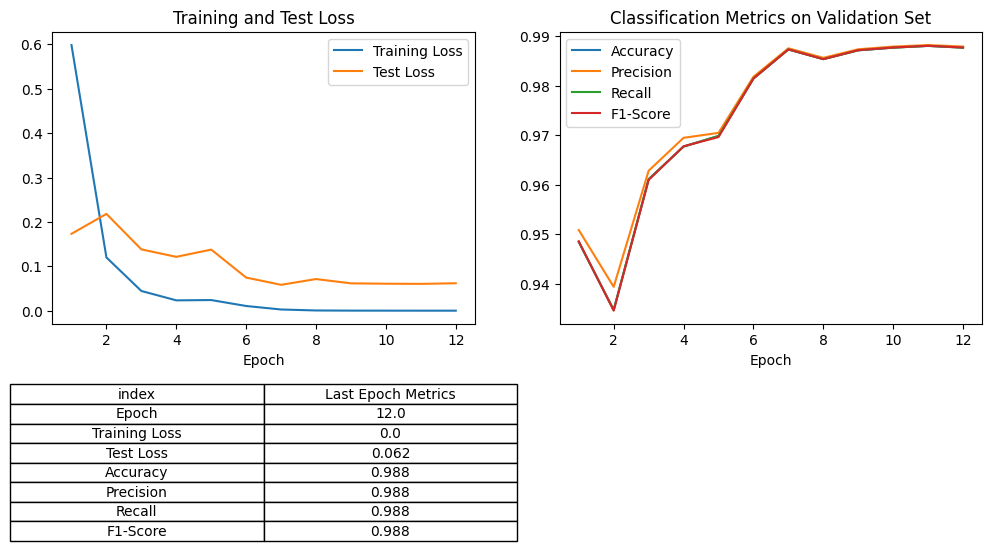

Training completed in: 4014.42 seconds


In [ ]:
from train import train

# check if model has already been trained
if os.path.exists(f'models/resnet_model_{num_features}.pth'):
    # Load the state dictionary
    state_dict = torch.load(f'models/resnet_model_{num_features}.pth', weights_only=True)
    # Remove 'model.' prefix from keys if it's causing the mismatch
    state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}

    # Load the modified state dictionary
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    print('Model loaded')
    metrics = pd.read_csv(f'models/metrics_{num_features}.csv')
    print('Metrics: \n', metrics[-5:])
else:
    trained_model, metrics = train(model, train_dataset, val_dataset, num_epochs, batch_size, workers)
    # save the model
    trained_model.save(f'models/resnet_model_{num_features}.pth')
    # save the metrics
    metrics.to_csv(f'models/metrics_{num_features}.csv', index=False)
    

## Extract Features from last layer

In [7]:
# remove the last layer of the model and replace with an identity layer
model.model.fc = torch.nn.Identity()

# get the features from the model
train_features = np.zeros((len(train_dataset), num_features))
train_labels = np.zeros(len(train_dataset))
val_features = np.zeros((len(val_dataset), num_features))

batch_size = 64

print('Train dataset length: ', len(train_dataset))
for i in tqdm(range(0, len(train_dataset), batch_size), desc='Extracting features from the training dataset'):
    images_list, label_list = train_dataset[i: i+batch_size]
    images = torch.stack(images_list, dim=0)
    features = model(images)
    train_features[i: i+batch_size] = features.detach().numpy()
    train_labels[i: i+batch_size] = label_list

print('Validation dataset length: ', len(val_dataset))
for i in tqdm(range(0, len(val_dataset), batch_size), desc='Extracting features from the validation dataset'):
    images_list, _ = val_dataset[i: i+batch_size]
    images = torch.stack(images_list, dim=0)
    features = model(images)
    val_features[i: i+batch_size] = features.detach().numpy()

Train dataset length:  16818


Extracting features from the training dataset: 100%|██████████| 263/263 [02:53<00:00,  1.52it/s]


Validation dataset length:  5606


Extracting features from the validation dataset: 100%|██████████| 88/88 [00:57<00:00,  1.53it/s]


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer
class SimpleScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.maximum = np.max(X)
        self.minimum = np.min(X)
        return self

    def transform(self, X):
        return (X - self.minimum) / (self.maximum - self.minimum)

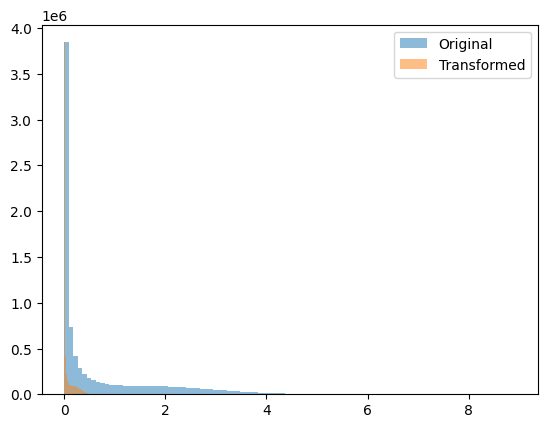

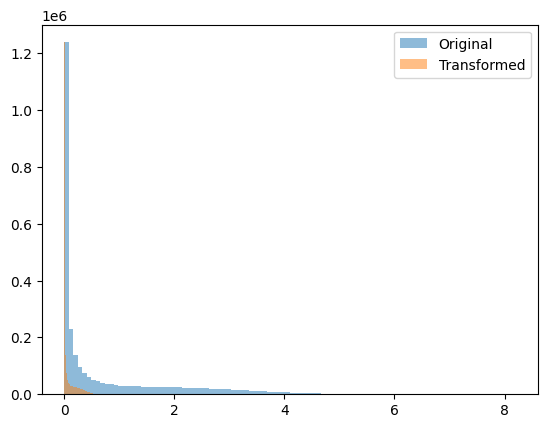

In [9]:
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Define the pipeline with each scaler in order
scaler_pipeline = Pipeline([
    ('simple_scaler', SimpleScaler())
])

# Flatten the features to 1D and transform them (for plotting purposes)
flat_train_features = train_features.flatten().reshape(-1, 1)
transformed_train_features_flat = scaler_pipeline.fit_transform(flat_train_features)

# plot the normalised scaled features
plt.hist(flat_train_features, bins=100, alpha=0.5, label='Original')
plt.hist(transformed_train_features_flat, bins=100, alpha=0.5, label='Transformed')
plt.legend()
plt.show()

# Flatten the features to 1D and transform them (for plotting purposes)
flat_val_features = val_features.flatten().reshape(-1, 1)
transformed_val_features_flat = scaler_pipeline.transform(flat_val_features)

# plot the normalised scaled features
plt.hist(val_features.flatten(), bins=100, alpha=0.5, label='Original')
plt.hist(transformed_val_features_flat, bins=100, alpha=0.5, label='Transformed')
plt.legend()
plt.show()

In [10]:
transformed_train_features = scaler_pipeline.transform(train_features)
transformed_val_features = scaler_pipeline.transform(val_features)

In [11]:
# save the scaler pipeline
import joblib
joblib.dump(scaler_pipeline, f'models/scaler_pipeline_{num_features}.joblib')

['models/scaler_pipeline_512.joblib']

## Encode Features in Hyperdimensional Vectors

In [12]:
import importlib
import hd_computing  # Ensure this initial import is done

# Reload the module after making changes to hd_computing.py
importlib.reload(hd_computing)

# Re-import specific classes and functions
from hd_computing import HDComputing, create_level_hvs, create_position_hvs, encode_features, create_class_prototypes

hd = HDComputing(dim)

# create the level hypervectors
level_hvs = create_level_hvs(num_levels, hd)

# create the position hypervectors
position_hvs = create_position_hvs(num_features, hd)

In [13]:
train_encoded = np.zeros((len(transformed_train_features), dim))
val_encoded = np.zeros((len(transformed_val_features), dim))

batch_size = 256

# encode the features
for i in tqdm(range(0, len(transformed_train_features), batch_size), desc='Encoding training features'):
    encoded_features = encode_features(transformed_train_features[i: i+batch_size], hd, num_levels, level_hvs, position_hvs)
    train_encoded[i: i+batch_size] = encoded_features

for i in tqdm(range(0, len(transformed_val_features), batch_size), desc='Encoding validation features'):
    encoded_features = encode_features(transformed_val_features[i: i+batch_size], hd, num_levels, level_hvs, position_hvs)
    val_encoded[i: i+batch_size] = encoded_features

Encoding validation features: 100%|██████████| 22/22 [02:35<00:00,  7.07s/it]


## Build Class Prototypes to Infer from Hyperdimensional Vectors

In [14]:
class_prototypes  = create_class_prototypes(train_encoded, train_labels, num_classes, hd, pecentile=0.5, voting_threshold=0.5)

In [15]:
train_predicted = np.zeros(len(train_encoded))
test_predicted = np.zeros(len(val_encoded))

for i in tqdm(range(len(train_encoded))):
    hv = train_encoded[i]
    similarity = [hd.cosine_similarity(hv, class_prototypes[j]) for j in range(num_classes)]
    predicted_class = np.argmax(similarity)
    train_predicted[i] = predicted_class

for i in tqdm(range(len(val_encoded))):
    hv = val_encoded[i]
    similarity = [hd.cosine_similarity(hv, class_prototypes[j]) for j in range(num_classes)]
    predicted_class = np.argmax(similarity)
    test_predicted[i] = predicted_class

100%|██████████| 5606/5606 [00:00<00:00, 9544.81it/s]


In [16]:
# calculate the metrics
accuracy_train = np.sum(train_predicted == train_labels)/len(train_labels)
accuracy_test = np.sum(test_predicted == val_image_list['classname'])/len(val_image_list)

from sklearn.metrics import precision_recall_fscore_support

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_labels, train_predicted, average='weighted', zero_division=0)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(val_image_list['classname'], test_predicted, average='weighted', zero_division=0)

print(f'Precision on the training dataset: {train_precision:.4f}')
print(f'Recall on the training dataset: {train_recall:.4f}')
print(f'F1 score on the training dataset: {train_f1:.4f}')
print(f'Accuracy on the training dataset: {accuracy_train:.4f}')

print(f'Precision on the validation dataset: {test_precision:.4f}')
print(f'Recall on the validation dataset: {test_recall:.4f}')
print(f'F1 score on the validation dataset: {test_f1:.4f}')
print(f'Accuracy on the validation dataset: {accuracy_test:.4f}')


Precision on the training dataset: 1.0000
Recall on the training dataset: 1.0000
F1 score on the training dataset: 1.0000
Accuracy on the training dataset: 1.0000
Precision on the validation dataset: 0.9880
Recall on the validation dataset: 0.9879
F1 score on the validation dataset: 0.9879
Accuracy on the validation dataset: 0.9879


Similarity scores:  [0.693, 0.601, 0.581, 0.599, 0.673, 0.616, 0.611, 0.606, 0.607, 0.608]


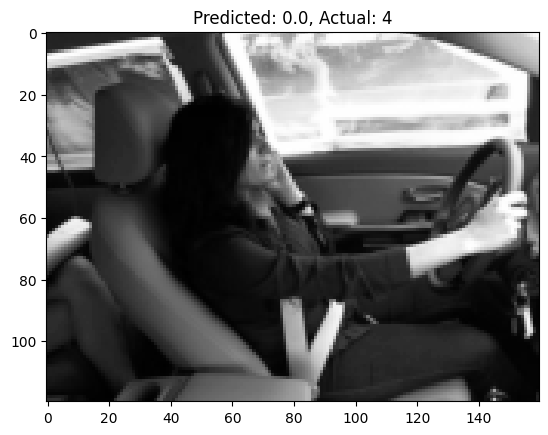

Similarity scores:  [0.588, 0.628, 0.619, 0.605, 0.634, 0.627, 0.728, 0.66, 0.666, 0.592]


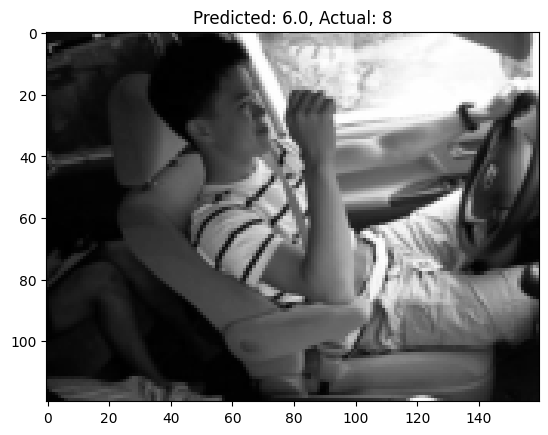

Similarity scores:  [0.724, 0.627, 0.6, 0.618, 0.634, 0.647, 0.602, 0.626, 0.625, 0.687]


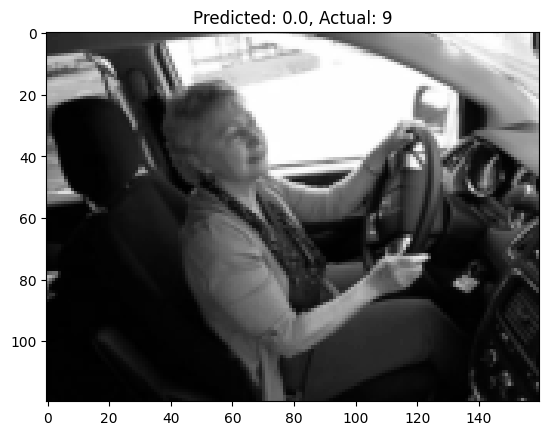

Similarity scores:  [0.678, 0.7, 0.634, 0.73, 0.671, 0.654, 0.652, 0.646, 0.621, 0.675]


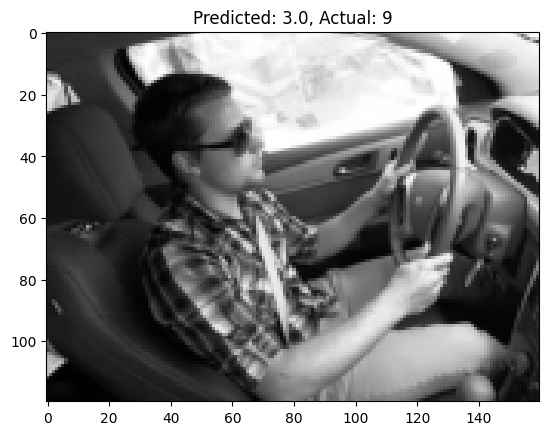

Similarity scores:  [0.684, 0.611, 0.567, 0.676, 0.599, 0.624, 0.56, 0.577, 0.574, 0.597]


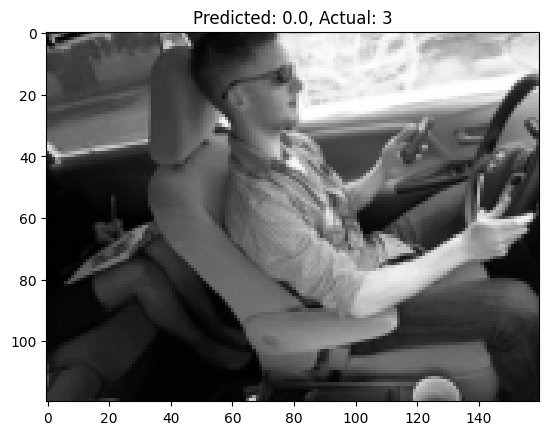

Similarity scores:  [0.595, 0.691, 0.631, 0.629, 0.614, 0.612, 0.691, 0.61, 0.595, 0.594]


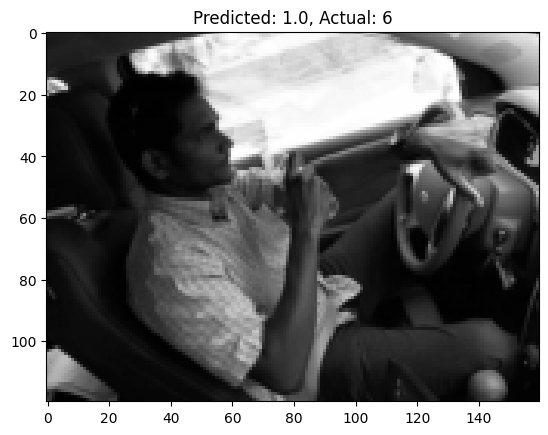

Similarity scores:  [0.726, 0.615, 0.586, 0.606, 0.637, 0.635, 0.6, 0.615, 0.617, 0.676]


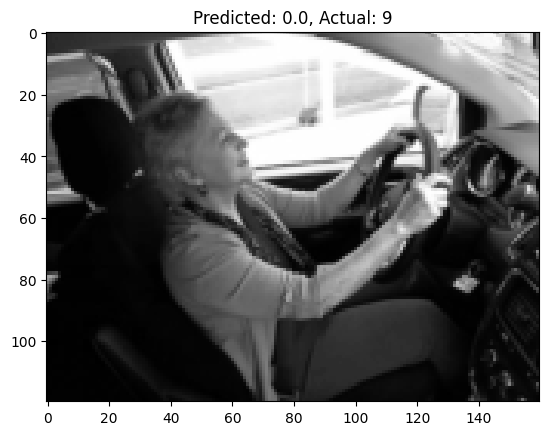

Similarity scores:  [0.581, 0.595, 0.83, 0.605, 0.593, 0.583, 0.602, 0.622, 0.598, 0.576]


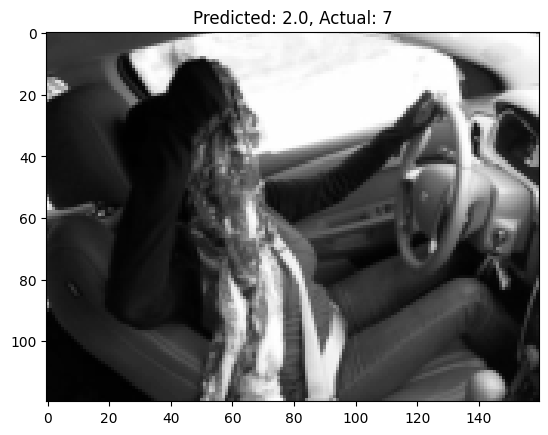

Similarity scores:  [0.735, 0.643, 0.613, 0.678, 0.623, 0.635, 0.595, 0.61, 0.593, 0.621]


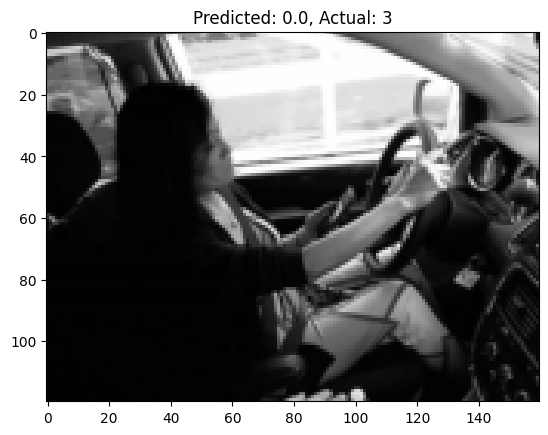

Similarity scores:  [0.569, 0.572, 0.564, 0.565, 0.597, 0.592, 0.591, 0.603, 0.803, 0.593]


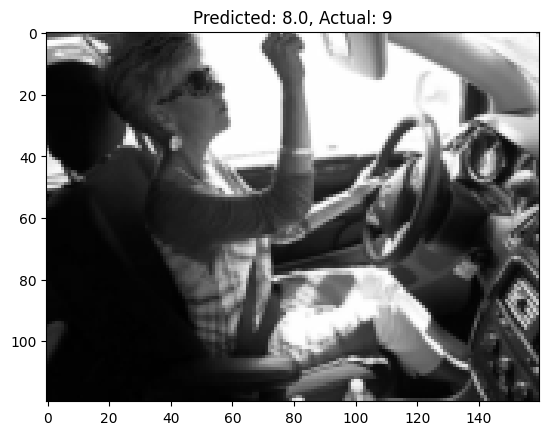

In [17]:
# find the indices of the misclassified images
mask = test_predicted != val_image_list['classname']
misclassified_indices = val_image_list[mask].index
misclassified_indices = misclassified_indices[:10]

# display the misclassified images
import matplotlib.pyplot as plt
for i in misclassified_indices:
    image, label = val_dataset[i]
    plt.imshow(image[0], cmap='gray')
    plt.title(f'Predicted: {test_predicted[i]}, Actual: {label}')
    
    # print similarity scores
    hv = val_encoded[i]
    similarity = [round(float(hd.average_similarity(hv, class_prototypes[j])),3) for j in range(num_classes)]
    print('Similarity scores: ', similarity)
    plt.show()


## Kaggle Submission

In [18]:
from torchvision.io import read_image

path = 'data/imgs/test/'

# create an image list for the test dataset with all file names in the test folder
test_df = pd.DataFrame({'img': os.listdir(path)})

print('test image list: ', test_df.head())


transform = v2.Compose([
    v2.ToImage(),  # Ensures the input is treated as an image
    v2.Resize(image_resize),
    v2.Grayscale(),
    v2.ToDtype(torch.float32, scale=True),
    ])

image_tensors = []
for i in tqdm(range(len(test_df)), desc='Loading test images'):
    image_path = path + test_df['img'][i]
    image = read_image(image_path)
    image = transform(image)
    image_tensors.append(image)

image_tensors = torch.stack(image_tensors, dim=0)

test image list:               img
0  img_60161.jpg
1  img_94786.jpg
2  img_85853.jpg
3  img_36327.jpg
4  img_39014.jpg


Loading test images: 100%|██████████| 79726/79726 [02:59<00:00, 444.13it/s]


In [19]:
test_features = np.zeros((len(test_df), num_features))
batch_size = 256

for i in tqdm(range(0, len(test_df), batch_size), desc='Extracting features from the test dataset'):
    images = image_tensors[i: i+batch_size]
    features = model(images)
    test_features[i: i+batch_size] = features.detach().numpy()


Extracting features from the test dataset: 100%|██████████| 312/312 [11:32<00:00,  2.22s/it]


Transformed test features shape:  (79726, 512)


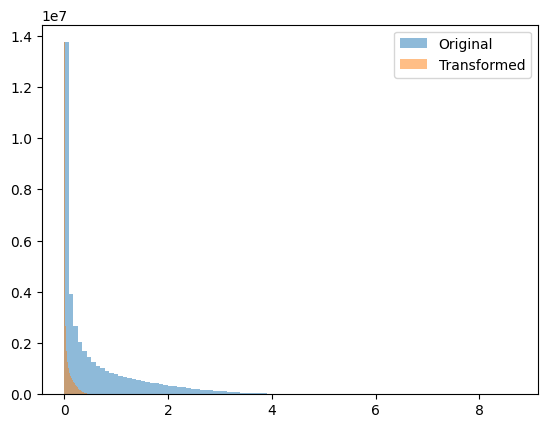

In [25]:
# normalize the features
transformed_test_features = scaler_pipeline.transform(test_features)

# flatten for plotting
flat_test_features = test_features.flatten().reshape(-1, 1)
flat_transformed_test_features = transformed_test_features.flatten().reshape(-1, 1)

# plot the normalised scaled features
plt.hist(flat_test_features, bins=100, alpha=0.5, label='Original')
plt.hist(flat_transformed_test_features, bins=100, alpha=0.5, label='Transformed')
plt.legend()

print('Transformed test features shape: ', transformed_test_features.shape)

In [21]:
test_encoded = np.zeros((len(transformed_test_features), dim))

for i in tqdm(range(0, len(transformed_test_features), batch_size), desc='Encoding test features'):
    encoded_features = encode_features(transformed_test_features[i: i+batch_size], hd, num_levels, level_hvs, position_hvs)
    test_encoded[i: i+batch_size] = encoded_features

Encoding test features: 100%|██████████| 312/312 [41:51<00:00,  8.05s/it]


In [30]:
def scaled_softmax(vector, base=np.e):
    exp_vector = base ** vector
    probabilities = exp_vector / np.sum(exp_vector)
    return probabilities

In [47]:
def amplify_probabilities(vector, power=2.0):
    exp_vector = np.exp(vector)  # Apply standard softmax
    probabilities = exp_vector / np.sum(exp_vector)
    amplified = np.power(probabilities, power)  # Raise to a power
    normalized_amplified = amplified / np.sum(amplified)  # Normalize
    return normalized_amplified

In [61]:
test_probabilities = np.zeros((len(test_encoded), num_classes))
iterations = len(test_encoded)

for i in tqdm(range(iterations)):
    hv = test_encoded[i]
    similarities = np.array([hd.cosine_similarity(hv, class_prototypes[j]) for j in range(num_classes)]).astype(np.float64)
    similarities -= np.min(similarities)
    softmax_probabilities = scaled_softmax(similarities, base=np.e)
    amplified_probabilities = amplify_probabilities(similarities, power=15.0)
    test_probabilities[i] = amplified_probabilities

test_df = pd.DataFrame({
    'img': test_df['img'],
    'c0': test_probabilities[:, 0],
    'c1': test_probabilities[:, 1],
    'c2': test_probabilities[:, 2],
    'c3': test_probabilities[:, 3],
    'c4': test_probabilities[:, 4],
    'c5': test_probabilities[:, 5],
    'c6': test_probabilities[:, 6],
    'c7': test_probabilities[:, 7],
    'c8': test_probabilities[:, 8],
    'c9': test_probabilities[:, 9],
})

# export subission.csv
test_df.to_csv('data/submission.csv', index=False)

100%|██████████| 79726/79726 [00:12<00:00, 6635.19it/s]


In [62]:
# print n first rows of the submission
print(test_df.head())

             img        c0        c1        c2        c3        c4        c5  \
0  img_60161.jpg  0.019567  0.018059  0.014318  0.038777  0.030674  0.733474   
1  img_94786.jpg  0.008931  0.030203  0.016675  0.012640  0.017055  0.018932   
2  img_85853.jpg  0.045506  0.633464  0.033410  0.034985  0.044823  0.038750   
3  img_36327.jpg  0.059981  0.260498  0.050670  0.065690  0.070297  0.072097   
4  img_39014.jpg  0.199703  0.081741  0.033012  0.069160  0.040313  0.418541   

         c6        c7        c8        c9  
0  0.034660  0.036078  0.043382  0.031013  
1  0.846914  0.024077  0.013842  0.010731  
2  0.029244  0.066651  0.035817  0.037349  
3  0.104516  0.093660  0.107229  0.115363  
4  0.040313  0.048588  0.038926  0.029705  
